# Crash 2 Dataset

## Data Supplier

This data was supplied by the Vanderbilt Department of Biostatistics at http://hbiostat.org/data/ accessed in Jan 2023.

Vanderbilt obtained this data from a clinical trial dataset originally provided by the  Bank of Injury and Emergency Research Data from the UK.

## Data Description
This data represents patients in a clinical trail who received treatment after physical trauma.
- 20207 observations and 44 variables
- **Full data source description** can be accessed at http://hbiostat.org/data/repo/crash2.html or in this project's data folder in [crash2.html](data/crash2.hml).
- **Data dictionary** available at http://hbiostat.org/data/repo/Ccrash2.html or in this project's data folder in [Ccrash2.hml](data/Ccrash2.hml)
  - I have converted the table of the html data dictionary to a csv: [crash_dictionary.csv](data/crash_dictionary.csv)

In [2]:
import pandas as pd
import numpy as np
import sklearn
import panel as pn
import re
from bokeh.plotting import figure, show
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
pn.extension(comms='vscode')

In [3]:

#import the data dictionary using a custom module
# import sys
# sys.path.append('./')
import crash_dictionary
crash_info = crash_dictionary.CrashDict('./data/crash_dictionary.csv')
display(crash_info.get_labels(['gcs','source']))
display(crash_info.get_details('cause'))
# crash_info.get_df()

,Labels
Name,
gcs,Glasgow Coma Score Total
source,Method of Transmission of Entry Form to CC


,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
cause,Main Cause of Death,NaN,7.0,NaN,integer,17118


In [4]:
crash_df = pd.read_stata('./data/crash2.dta')

In [5]:
default_max_columns = 20
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', default_max_columns)

In [6]:

display(crash_df.sample(n = 3))
# print(crash_df.sample(n = 3))


,entryid,source,trandomised,outcomeid,sex,age,injurytime,injurytype,sbp,rr,cc,hr,gcseye,gcsmotor,gcsverbal,gcs,ddeath,cause,scauseother,status,ddischarge,condition,ndaysicu,bheadinj,bneuro,bchest,babdomen,bpelvis,bpe,bdvt,bstroke,bbleed,bmi,bgi,bloading,bmaint,btransf,ncell,nplasma,nplatelets,ncryo,bvii,boxid,packnum
11710,11733,electronic CRF by email,17803.0,19596.0,male,43.0,2.0,blunt and penetrating,140.0,22.0,4.0,110.0,1.0,5.0,1.0,7.0,17806.0,head injury,,NaN,NaN,NaN,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,6.0,4.0,0.0,0.0,0.0,8645,81
19307,19361,electronic CRF,18175.0,17799.0,male,25.0,2.0,blunt,100.0,20.0,3.0,100.0,4.0,6.0,5.0,15.0,NaN,NaN,,still in hospital,18203.0,some restriction in lifestyle but independent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,3028,31
8092,8110,electronic CRF,17580.0,7459.0,male,23.0,3.0,blunt,90.0,20.0,1.0,90.0,0.0,0.0,0.0,15.0,NaN,NaN,,discharged,17590.0,minor symptoms,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,8431,84


# Evaluate missing data

In [7]:
crash_df_count = crash_df.count()
value_count_df = pd.DataFrame({ 
    "entered-values": crash_df_count,
    "missing-values": len(crash_df) - crash_df_count
    }, 
    index = crash_df.columns
)

incomplete_features_df = value_count_df.loc[value_count_df["missing-values"]>0]
qty_features = len(crash_df.columns)
qty_incomplete_features = len(incomplete_features_df.index)
qty_complete_features = qty_features - qty_incomplete_features
names_complete_features = set(crash_df.columns).difference(set(incomplete_features_df.index))

print(f"Number of observations        : {len(crash_df)}")
print(f"Number of features            : {qty_features}")
print(f"Number of incomplete features : {qty_incomplete_features}")
print(f"Number of complete features   : {qty_complete_features}")
print(f"Names of complete features    : {names_complete_features}")

Number of observations        : 20207
Number of features            : 44
Number of incomplete features : 37
Number of complete features   : 7
Names of complete features    : {'trandomised', 'entryid', 'boxid', 'scauseother', 'packnum', 'source', 'injurytype'}


<AxesSubplot: title={'center': 'features with missing values'}>

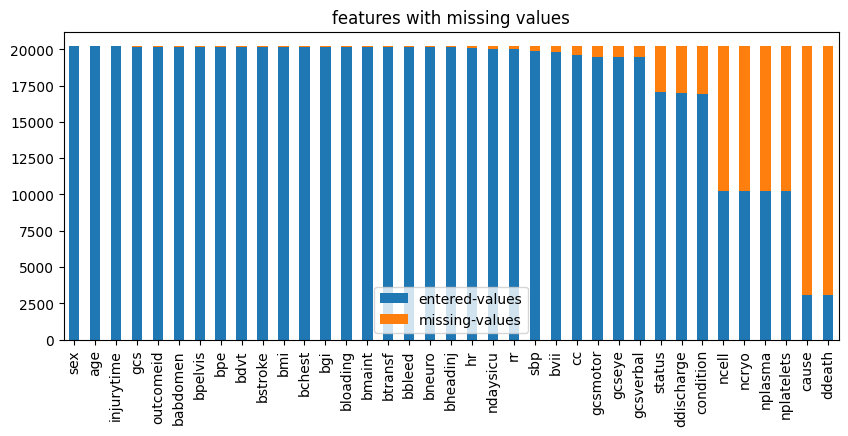

In [8]:

# missing_values_df = value_count_df.drop(complete_features)
incomplete_features_df.sort_values(by=['missing-values']).plot.bar(title='features with missing values', stacked=True, figsize=(10,4))

## Fixing the GCS values

GCS stands for Glasgow Coma Score

According to wikipedia, the best possible score is a 15 and 3 is the worst

The GCS total is a sum of scores for Verbal Response, Mortor Response, and Eye Opening

In [9]:
gcs_info=crash_info.df[crash_info.index.str.startswith("gcs")]
gcs_info

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
gcseye,Glasgow Coma Score Eye Opening,NaN,NaN,integer,integer,732
gcsmotor,Glasgow Coma Score Motor Response,NaN,NaN,integer,integer,732
gcsverbal,Glasgow Coma Score Verbal Response,NaN,NaN,integer,integer,735
gcs,Glasgow Coma Score Total,NaN,NaN,integer,integer,23


We can confirm that our GCS totals range between 3 and 15 as seen below. According to Wikipedia the value should be between 3 and 15, so this looks good!

In [10]:
gcs_df =crash_df[['entryid','gcs', 'gcseye', 'gcsmotor', 'gcsverbal']]
gcs_df.agg([min, max])

,entryid,gcs,gcseye,gcsmotor,gcsverbal
min,1,3.0,0.0,0.0,0.0
max,20270,15.0,4.0,6.0,5.0


In [11]:

display(gcs_df.head())
gcs_long_df = gcs_df.sample(100)
gcs_long_df = pd.melt(
    gcs_long_df,
    id_vars='entryid', 
    var_name="gcs_component", 
    value_name="score"
    ).sort_values(by=["entryid","gcs_component"]).reset_index(drop=True)
display(gcs_long_df.head(8))

,entryid,gcs,gcseye,gcsmotor,gcsverbal
0,1,3.0,1.0,1.0,1.0
1,2,15.0,4.0,6.0,5.0
2,3,14.0,4.0,6.0,4.0
3,4,10.0,2.0,5.0,3.0
4,5,14.0,3.0,6.0,5.0


,entryid,gcs_component,score
0,50,gcs,15.0
1,50,gcseye,4.0
2,50,gcsmotor,6.0
3,50,gcsverbal,5.0
4,53,gcs,15.0
5,53,gcseye,4.0
6,53,gcsmotor,6.0
7,53,gcsverbal,5.0


### Long Cell - gcs_heatmap() function
This cell is a bit longer - you can skip past it to get to the visual analysis.

In [12]:
def gcs_heatmap(hm_df:pd.DataFrame, sample_size:int=None, max_height=400, portrait=True, save_sample_ids=False, title="GCS Heatmap"):
       """create a heatmap of a gcs dataframe, highlighting null values in red"""
       if(save_sample_ids):
              sample_ids = hm_df['entryid']
       if(sample_size is not None):
              hm_df = hm_df.sample(sample_size)
       # convert the table from a wide format to a long format
       hm_df = pd.melt(
              hm_df,
              id_vars='entryid', 
              var_name="gcs_component", 
              value_name="score"
       ).sort_values(by=["entryid","gcs_component"]).reset_index(drop=True)

       # bokeh plots require x/y ranges to be str values
       hm_df = hm_df.astype({
              'entryid':'string',
              'gcs_component' : 'string',
              # 'score' : 'int32',
       })

       #make a mappable number out of na
       hm_df.fillna(-1, inplace=True)

       # Create a color palet that will make it easy to spot NA values
       from bokeh.palettes import cividis
       from bokeh.palettes import Reds3
       my_palette = list(reversed(list(cividis(14))))
       my_palette.append(Reds3[0])  # color for 0 values (invalid)
       my_palette.append('#FFFFFF') # color for -1 values (previously NA)
       my_palette = list(reversed(my_palette))

       # the mapper defines how colors are applied
       mapper = LinearColorMapper(palette=my_palette, low=-1, high=gcs_df.gcs.max())

       # CREATE THE PLOT
       # set tool options
       TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

       # landscape orientation
       x_range=hm_df.entryid.unique().tolist() 
       y_range=hm_df.gcs_component.unique().tolist()
       x="entryid" 
       y="gcs_component"
       width=900 
       height=400
       x_major_label_orientation=1.5
       
       # portrait orientation
       if portrait:
              x_range=hm_df.gcs_component.unique().tolist()
              y_range=hm_df.entryid.unique().tolist() 
              x="gcs_component"
              y="entryid" 
              width=600 
              scaled_height = round(2.2*len(hm_df))
              max_height = max_height
              min_height = 150
              height = scaled_height if scaled_height < max_height else max_height
              height = height if height > min_height else min_height
              x_major_label_orientation=0

       # initiate the plot by creating a figure
       p = figure(title=title,
              x_range=x_range, y_range=y_range,
              x_axis_location="above", 
              width=width, height=height,
              tools=TOOLS, toolbar_location='below',
              tooltips=[('gcs_component', '@gcs_component'), ('score', '@score'),('entryid','@entryid')])

       p.grid.grid_line_color = None
       p.axis.axis_line_color = None
       p.axis.major_tick_line_color = None
       p.xaxis.major_label_text_font_size = "11px"
       p.yaxis.major_label_text_font_size = "8px"
       p.axis.major_label_standoff = 0
       p.xaxis.major_label_orientation = x_major_label_orientation
       if height == max_height:
              p.yaxis.visible = False    

       p.rect(x=x, y=y, width=1, height=1,
              source=hm_df,
              fill_color={'field': 'score', 'transform': mapper},
              line_color=None)

       color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="11px",
                            ticker=BasicTicker(desired_num_ticks=16),
                            # formatter=PrintfTickFormatter(format="%d%%"),
                            label_standoff=6, border_line_color=None,
                            major_tick_line_color = '#000000',
                            bar_line_color='#000000', bar_line_alpha=0.3)
       p.add_layout(color_bar, 'right')

       show(p)
       if save_sample_ids:
              return sample_ids

### GCS heatmap
High GCS scores indicate that a patient may have been in a very light comma. Low scores indicate a strong comma.
High scores (max 15) are indicated by yellow.
Low scores for eye, motor, verbal (min 1) indicated by blue. Total is an addition of all 3, so min total = 3.

### GCS scores: understanding zereo and NA values
`gcs` represents the total score. After revewing several random samples I've determined that there is no pattern to whether NA or 0 occures when GCS is a highest or lowest score. Zero appears to be the same as NA. Zero is not a meaningful number on the GCS for any component or for the total.

In [13]:
gcs_heatmap(gcs_df.sample(50), title="GCS Sample: random 50")

I've selected a few entry ID's showing different kinds of combinations encountered with the GSC Data

In [14]:
gcs_heatmap(gcs_df.loc[gcs_df['entryid'].isin([678,10025,10500,4208,2044,7049])], title="GCS scenario variety") 

### Missing GCS totals
When the total is missing it's completely missing. It's never zero. There are never any component scores.

In [15]:
gcs_na_total = gcs_df.loc[(gcs_df['gcs'].isna())|(gcs_df['gcs']==0)]
display(f"There are {len(gcs_na_total)} scores with na or 0")
gcs_heatmap(gcs_na_total, title="GCS Total Score is NA or Zero")

'There are 23 scores with na or 0'

### GCS Missing components
Normally all components are missing when they are missing. Occasionally `gcseye` and `gcsmotor` are present when `gcsverbal` is missing.

In [16]:
gcs_nan = gcs_df.loc[gcs_df.isna().agg("sum",axis='columns')>0]
display(f"entries with any NA value in GCS: {len(gcs_nan)}")
display(f"displaying the first 100 entries with NA values")
gcs_heatmap(gcs_nan.iloc[0:100], title='GCS Missing Values')

'entries with any NA value in GCS: 735'

'displaying the first 100 entries with NA values'

### GCS Components containing zeros
When any of the GCS compoenents contain zeros they follow the same patterns as missing values.

In [17]:
def iszero(s:pd.Series):
    """aggregation function. returns True if any element in a series is 0"""
    for i in s:
        if pd.isna(i):
            pass
        elif isinstance(i,bool):
            pass
        elif i == 0:
            return True
    return False

gcs_zeros_df = gcs_df.loc[gcs_df.agg(iszero, axis='columns')]
display(f"Entries with any 0 value in GCS: {len(gcs_zeros_df)}")
display("Number of zero entries per column")
display(gcs_zeros_df.applymap(lambda value: 0 if value>0 else 1).sum())

display(f"Displaying the 500th through 600th entries with 0 values")

zero_sample_ids = gcs_heatmap(gcs_zeros_df.iloc[500:600], title="GCS - Zero Values", save_sample_ids=True)

'Entries with any 0 value in GCS: 1642'

'Number of zero entries per column'

entryid         0
gcs             0
gcseye       1639
gcsmotor     1639
gcsverbal    1642
dtype: int64

'Displaying the 500th through 600th entries with 0 values'

### GCS conclusions and cleanup plan

#### Conclusions
- All 0 values can be considered missing.
- In some cases `gscverbal` can be computed from the total and the eye/motor components.
- assuming that all entries should have a GCS seems low risk, considering that are missing from 23 out of 20207

#### Cleanup plan
- convert all 0 values to NA values for uniformity when imputing.
- impute all missing eye/motor/total components
- finally compute all missing verbal components

In [18]:
crash_df.replace({'gcseye': 0, 'gcsmotor': 0, 'gcsverbal': 0,}, np.nan, inplace=True)

If we did this replacement correctly we'll excpet to see these new NA values

|            |Zeros|   |NAs|   |New NAs|
|------------|-----|---|---|---|-------|
|gcseye      | 1639| + |732| = |2371   |
|gcsmotor    | 1639| + |732| = |2371   |
|gcsverbal   | 1642| + |735| = |2377   |

In [19]:
crash_df[['entryid','gcs', 'gcseye', 'gcsmotor', 'gcsverbal']].isna().sum()

entryid         0
gcs            23
gcseye       2371
gcsmotor     2371
gcsverbal    2377
dtype: int64

We'll work on imputing this later

### Transfusion Variables

I hoped that it would make sense to assume that no transfusion value meant that no transfusion had occurred. However there are so many zero values in these variables that I can't easily assume that.

In [20]:
transfusion_vars = ['ncell','ncryo','nplasma','nplatelets']
display(crash_info.get_details(transfusion_vars))
trans_df = crash_df.loc[:,transfusion_vars]
# trans_df.agg(['min','max'])
display("Non-zero, non-na values in trans vars")
for tv in transfusion_vars:
    display(trans_df.loc[(trans_df[tv]>0),[tv]].count())

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
ncell,Number of Units of Red Call Products Transfused,NaN,NaN,numeric,double,9963
ncryo,Number of Units of Cryoprecipitate Transfused,NaN,NaN,integer,integer,9964
nplasma,Number of Units of Fresh Frozen Plasma Transfused,NaN,NaN,integer,integer,9964
nplatelets,Number of Units of Platelets Transfused,NaN,NaN,integer,integer,9964


'Non-zero, non-na values in trans vars'

ncell    10154
dtype: int64

ncryo    392
dtype: int64

nplasma    2633
dtype: int64

nplatelets    806
dtype: int64

Considering the huge number of NA values I'm going to drop these columns instead of imputing them. It might make sense in a different study to analize only rows that contain transfusion values.

In [21]:
crash_df.drop(columns=transfusion_vars, inplace=True)
crash_df.head(2)

,entryid,source,trandomised,outcomeid,sex,age,injurytime,injurytype,sbp,rr,cc,hr,gcseye,gcsmotor,gcsverbal,gcs,ddeath,cause,scauseother,status,ddischarge,condition,ndaysicu,bheadinj,bneuro,bchest,babdomen,bpelvis,bpe,bdvt,bstroke,bbleed,bmi,bgi,bloading,bmaint,btransf,bvii,boxid,packnum
0,1,electronic CRF by email,16598.0,2.0,male,50.0,1.0,blunt,75.0,28.0,5.0,120.0,1.0,1.0,1.0,3.0,16601.0,head injury,,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2001,25
1,2,electronic CRF by email,16585.0,190.0,female,27.0,1.0,blunt,100.0,20.0,2.0,80.0,4.0,6.0,5.0,15.0,NaN,NaN,,discharged,16611.0,minor symptoms,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2001,28


In [22]:
crash_info.df

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
entryid,Unique Numbers for Entry Forms,NaN,NaN,integer,integer,0
source,Method of Transmission of Entry Form to CC,NaN,5.0,NaN,integer,0
trandomised,Date of Randomization,NaN,NaN,Date,double,0
outcomeid,Unique Number From Outcome Database,NaN,NaN,integer,integer,80
sex,NaN,NaN,2.0,NaN,integer,1
age,NaN,NaN,NaN,NaN,integer,4
injurytime,Hours Since Injury,NaN,NaN,numeric,double,11
injurytype,NaN,NaN,3.0,NaN,integer,0
sbp,Systolic Blood Pressure,mmHg,NaN,integer,integer,320


### Dealing with death
There are 3 variables that relate to death, and a discharge variable that make a good sanity check.

In [23]:
crash_info.get_labels(['ddeath','cause','scauseother','ddischarge'])

,Labels
Name,
ddeath,Date of Death
cause,Main Cause of Death
scauseother,Description of Other Cause of Death
ddischarge,"Date of discharge, transfer to other hospital ..."


Looking at the missing values and how they line up I think I can make a few assumptions.
In a real clinical analysis we might want someone involved with the clinical trial to help us validate these.
- If they don't have a death date they did not die
- If they don't have a discharge date they have not been discharged.
- If they died their should be a cause
- If they did not die their should not be a cause

I'm going to make some test changes, and if everything lines up I'll push them into crash_db

For purposes of my analysis, I'm not going to work with durations. I'm going to treat discharge and death as true and false.

In [24]:
test_df = crash_df.loc[:,['ddeath', 'cause', 'scauseother','ddischarge']]
#convert ddeath and ddischarge to bool
    # assumption:if they have no death date they did not die
test_df.loc[:,'ddeath'] = test_df.loc[:,'ddeath'].map(lambda value: False if pd.isna(value) else True)
    # assumption:if they have no discharge date they haven't been dischraged and will not have been recorded as dead.
test_df.loc[:,'ddischarge'] = test_df.loc[:,'ddischarge'].map(lambda value: False if pd.isna(value) else True)
# categorical data - add the category first, then fillna can apply the new category
test_df.cause = test_df.cause.cat.add_categories("not applicable")
test_df.loc[:,'cause'].fillna("not applicable", inplace=True)
test_df.scauseother = test_df.scauseother.cat.rename_categories({"":"not applicable"})
print(test_df.dtypes)

print("Deaths with no cause listed:")
display(
    test_df.loc[(
        (test_df['ddeath']==True)
        &(test_df['scauseother']=='not applicable')
        &(test_df['cause']=='not applicable'))]
    )
print("Non-deaths with a listed cause:")
display(test_df.loc[(
    (test_df['ddeath']==False)
    &((test_df['scauseother']!='not applicable')|(test_df['cause']!='not applicable')))])

print("Deaths with a discharge date:")
display(test_df.loc[((test_df['ddeath']==True)&(test_df['ddischarge']==True))])
# display(test_df.loc[((test_df['ddeath']==True)&(test_df['ddischarge'].notna()))])


ddeath             bool
cause          category
scauseother    category
ddischarge         bool
dtype: object
Deaths with no cause listed:


,ddeath,cause,scauseother,ddischarge


Non-deaths with a listed cause:


,ddeath,cause,scauseother,ddischarge
2691,False,multi organ failure,not applicable,False
6327,False,multi organ failure,not applicable,False
11922,False,multi organ failure,not applicable,False


Deaths with a discharge date:


,ddeath,cause,scauseother,ddischarge


We do see 3 cases where we don't have a death date but we do have a convincing reason for death. As these individuals were also not discharged we'll manually change them to True in the ddeath column.

In [25]:

test_df.iloc[2691,0] = True
test_df.iloc[6327,0] = True
test_df.iloc[11922,0] = True

print("Non-deaths with a listed cause:")
display(test_df.loc[(
    (test_df['ddeath']==False)
    &((test_df['scauseother']!='not applicable')|(test_df['cause']!='not applicable')))])

Non-deaths with a listed cause:


,ddeath,cause,scauseother,ddischarge


Saving the changes

In [26]:
for col in ['ddeath','cause','scauseother','ddischarge']:
    print(f"saving: {col}")
    crash_df.loc[:,col] = test_df.loc[:,[col]]

saving: ddeath
saving: cause
saving: scauseother
saving: ddischarge


/tmp/ipykernel_9785/1436625915.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  crash_df.loc[:,col] = test_df.loc[:,[col]]
/tmp/ipykernel_9785/1436625915.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  crash_df.loc[:,col] = test_df.loc[:,[col]]


In [27]:
crash_df.head()

,entryid,source,trandomised,outcomeid,sex,age,injurytime,injurytype,sbp,rr,cc,hr,gcseye,gcsmotor,gcsverbal,gcs,ddeath,cause,scauseother,status,ddischarge,condition,ndaysicu,bheadinj,bneuro,bchest,babdomen,bpelvis,bpe,bdvt,bstroke,bbleed,bmi,bgi,bloading,bmaint,btransf,bvii,boxid,packnum
0,1,electronic CRF by email,16598.0,2.0,male,50.0,1.0,blunt,75.0,28.0,5.0,120.0,1.0,1.0,1.0,3.0,True,head injury,not applicable,NaN,False,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2001,25
1,2,electronic CRF by email,16585.0,190.0,female,27.0,1.0,blunt,100.0,20.0,2.0,80.0,4.0,6.0,5.0,15.0,False,not applicable,not applicable,discharged,True,minor symptoms,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2001,28
2,3,electronic CRF by email,16581.0,4.0,male,30.0,1.0,blunt,70.0,26.0,6.0,130.0,4.0,6.0,4.0,14.0,False,not applicable,not applicable,discharged,True,no symptoms,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2011,21
3,4,electronic CRF by email,16582.0,5.0,male,40.0,2.0,penetrating,60.0,20.0,5.0,120.0,2.0,5.0,3.0,10.0,True,multi organ failure,not applicable,NaN,False,NaN,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2011,22
4,5,electronic CRF by email,16585.0,1154.0,female,23.0,4.0,penetrating,80.0,22.0,3.0,100.0,3.0,6.0,5.0,14.0,False,not applicable,not applicable,discharged,True,no symptoms,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2011,23


@TODO: should I have looked at status before converting the discharge dates??